Time Series data need to be remodelled in supervised data before starting any machine and deep learning algorithm.<br>
In EDA section ,it was found that the series we working on is Non-stationary where the two conditions - constant mean and constant variance were satisfied but the last condition that the series should not have any seasonality was not fulfilled.<br>
This make it difficult to model by both classical statistical method like Moving average,Exponential weighted average and more sophisticated machine learning and deep learning methods like XGboost,SVM,MLP,LSTM etc.<br>
So first we have to transform the non-stationary time series dataset into stationary dataset and for that we will include new features which will make series stationary automaticallt eg lag feature etc.

Other important reason for doing feature engineering is that in original data we have only 2 columns - datetime and PJME_Mw(traget variable).For statistical method of forecasting like AR,MA,ARMA etc it is not necessary to have other features than taget variables,but in supervised learning algorithm we as data scientist need to provide both input(features) and output(target) variables.

Feature Engineering mainly have two aims:<br>
- To increase performance of ML and DL models
- creating inputs for ML algorithm
In this case study we will do mainly four types of feature engineering that would be helpful in time series:<br>
- Date time features(already see in EDA section)
- Lag features/window features
- Rolling windows statistics
- Expanding windows statistics
- Fourier Transformation if cyclic datatype column is present

In features selection we will see which features are very important and select those features in final data

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings( 'ignore' )
pd.set_option('display.max_columns', None)

##### Reading data

In [2]:
pjm_data  = pd.read_pickle('pjm_data.pkl')


## Date time features

Date time features are features that are created from time stamp value.Some examples of date time features are hour,month,dayofweek,season,quarters etc.
Will do the same from EDA section

In [3]:
#we will keep dayofweek as numerical value only ,in EDA we converted it into categorical for data insights
pjm_data['date'] = pd.to_datetime(pjm_data['Datetime'].dt.date)
pjm_data['hour'] = pjm_data['Datetime'].dt.hour
pjm_data['dayofweek'] = pjm_data['Datetime'].dt.dayofweek
pjm_data['quarter'] = pjm_data['Datetime'].dt.quarter
pjm_data['month'] = pjm_data['Datetime'].dt.month
pjm_data['year'] = pjm_data['Datetime'].dt.year
pjm_data['dayofyear'] = pjm_data['Datetime'].dt.dayofyear
pjm_data['dayofmonth'] = pjm_data['Datetime'].dt.day
pjm_data['weekofyear'] = pjm_data['Datetime'].dt.weekofyear

###### Season
From EDA : <br>
Summer: June - August
Fall: September - November
Winter: December - February
Spring: March - May
    
we will keep it as numerical attribute else later we will have to use One-Hot Encoder to convert it to numerical attribute<br>
- winter : 1
- spring : 2
- summer : 3
- Fall : 4

In [4]:
def season_attribute(month):
    if month in [6,7,8]:#summer
        return 3
    elif month in [9,10,11]:#Fall
        return 4
    elif month in [12,1,2]:#winter
        return 1
    else:
        return 2#spring

In [5]:
pjm_data['season'] = pjm_data['Datetime'].dt.month.apply(season_attribute)

###### Holiday or not
we will add holiday column as per USA calender from 2002 to 2018.<br>
For that we will use Holiday library - https://pypi.org/project/holidays/ <br>

In [6]:
us_calender = USFederalHolidayCalendar()
pjm_data['public_holiday'] = pjm_data['date'].isin(us_calender.holidays(start = pjm_data['date'].min(),end = pjm_data['date'].max()))  

###### Working and Non-working day

Generally in USA there is a 5-day working system so considering it we can add other attribute working day and non working day which includes holidays as non-working daya and also weekends ie saturfay and sunday also as non working day
- **True** represents the day is working day
- **False** represents the day is Non-working day

In [7]:
pjm_data['workaday'] = pjm_data.apply(lambda i :False if ((i['public_holiday']==True) or (i['dayofweek'] in [5,6])) else True,axis=1)

## Lag features/windows fetures

Lag feature assumes that what happened in past influence the future<br>
For example it would be beneficial to generate features for whatever energy consumed in previous day at 4pm if we want to forecast/predict similar energy consumption at 4pm the next day.<br>
Initially we will take 7 lag features and see in Modelling section whether it is able to give required result ,if not, we will increase lag features


In [8]:
def create_lag_feature(data,attribute,maximum_lag):
    """ In this function the inputs are :
    data: which is the dataframe
    attribute: which represents columns on which lag feature to happen
    maximum_lag: which represents the max number of lag we want
    output : it will create columns equals to lag input
    
    for eg if we input maximum_lag =3 it will create 3 new columns to original dataframe which represents lag_1,lag_1,lag_3 features
    """
    for i in range(1,maximum_lag+1):
        data['lag_feature'+str(i)] = data[attribute].shift(i,freq='1H',fill_value=0)

In [9]:
#copying the original dataframe and setting datetime column as index
pjm_df = pjm_data.copy()
pjm_df.index = pjm_df['Datetime']
del pjm_df['Datetime']
pjm_df = pjm_df.sort_index()
pjm_df.head(3)

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,public_holiday,workaday
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002-01-01,1,1,1,1,2002,1,1,1,1,True,False
2002-01-01 02:00:00,29265.0,2002-01-01,2,1,1,1,2002,1,1,1,1,True,False
2002-01-01 03:00:00,28357.0,2002-01-01,3,1,1,1,2002,1,1,1,1,True,False


In [10]:
create_lag_feature(pjm_df,'PJME_MW',2)

In [11]:
pjm_df.head(10)

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,public_holiday,workaday,lag_feature1,lag_feature2
Datetime,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002-01-01,1,1,1,1,2002,1,1,1,1,True,False,NaN,NaN
2002-01-01 02:00:00,29265.0,2002-01-01,2,1,1,1,2002,1,1,1,1,True,False,30393.0,NaN
2002-01-01 03:00:00,28357.0,2002-01-01,3,1,1,1,2002,1,1,1,1,True,False,29265.0,30393.0
2002-01-01 04:00:00,27899.0,2002-01-01,4,1,1,1,2002,1,1,1,1,True,False,28357.0,29265.0
2002-01-01 05:00:00,28057.0,2002-01-01,5,1,1,1,2002,1,1,1,1,True,False,27899.0,28357.0
2002-01-01 06:00:00,28654.0,2002-01-01,6,1,1,1,2002,1,1,1,1,True,False,28057.0,27899.0
2002-01-01 07:00:00,29308.0,2002-01-01,7,1,1,1,2002,1,1,1,1,True,False,28654.0,28057.0
2002-01-01 08:00:00,29595.0,2002-01-01,8,1,1,1,2002,1,1,1,1,True,False,29308.0,28654.0
2002-01-01 09:00:00,29943.0,2002-01-01,9,1,1,1,2002,1,1,1,1,True,False,29595.0,29308.0


## Rolling window statistics

The main aim is to compute statistics on values from a given data sample  by defining arange that includes the sample itself as well as specified number of samples before and after the sample used

In [12]:
def rolling_window_feature(data,attribute,window_size,max_feature):
    ''' this function will return features realted to rooling window statistics
    the inputs are:
    data : the data to be passed
    attribute :  represents columns
    window size : the size of window,eg 24 for 1 day window,24*7 for a week windoe
    max_feature : the maximim feature we want ,for eg, if max_feature = 4 we want feature which are min,max,mean
    the output we will get a dataframe'''
    data_df = data[[attribute]]
    data_shift = data_df.shift(max_feature-1)
    rolling_window = data_shift.rolling(window=window_size)
    return rolling_window

In [13]:
#creating rolling features keeping window for 1 day
rolling_feature_day = rolling_window_feature(pjm_df,'PJME_MW',24,4)
pjm_df['rolling_day_min'] = rolling_feature_day.min()
pjm_df['rolling_day_mean'] = rolling_feature_day.mean()
pjm_df['rolling_day_max'] = rolling_feature_day.max()

In [14]:
#creating rolling features keeping window for a week
rolling_feature_week = rolling_window_feature(pjm_df,'PJME_MW',24*7,4)
pjm_df['rolling_week_min'] = rolling_feature_week.min()
pjm_df['rolling_week_mean'] = rolling_feature_week.mean()
pjm_df['rolling_week_max'] = rolling_feature_week.max()

## Expanding windows statistics

It create features that include all previous data.

In [15]:
pjme_attribute = pjm_df[['PJME_MW']]
expanding_window = pjme_attribute.expanding()
pjm_df['expanding_feature_min'] = expanding_window.min()
pjm_df['expanding_feature_mean'] = expanding_window.mean()
pjm_df['expanding_feature_max'] = expanding_window.max()

In [16]:
pjm_df.head(200)

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,public_holiday,workaday,lag_feature1,lag_feature2,rolling_day_min,rolling_day_mean,rolling_day_max,rolling_week_min,rolling_week_mean,rolling_week_max,expanding_feature_min,expanding_feature_mean,expanding_feature_max
Datetime,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002-01-01,1,1,1,1,2002,1,1,1,1,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30393.0,30393.000000,30393.0
2002-01-01 02:00:00,29265.0,2002-01-01,2,1,1,1,2002,1,1,1,1,True,False,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29265.0,29829.000000,30393.0
2002-01-01 03:00:00,28357.0,2002-01-01,3,1,1,1,2002,1,1,1,1,True,False,29265.0,30393.0,NaN,NaN,NaN,NaN,NaN,NaN,28357.0,29338.333333,30393.0
2002-01-01 04:00:00,27899.0,2002-01-01,4,1,1,1,2002,1,1,1,1,True,False,28357.0,29265.0,NaN,NaN,NaN,NaN,NaN,NaN,27899.0,28978.500000,30393.0
2002-01-01 05:00:00,28057.0,2002-01-01,5,1,1,1,2002,1,1,1,1,True,False,27899.0,28357.0,NaN,NaN,NaN,NaN,NaN,NaN,27899.0,28794.200000,30393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-01-09 04:00:00,27759.0,2002-01-09,4,2,1,1,2002,9,9,2,1,False,True,27829.0,28154.0,28375.0,34337.625000,39450.0,25641.0,33001.696429,40002.0,25641.0,32655.959184,40002.0
2002-01-09 05:00:00,28308.0,2002-01-09,5,2,1,1,2002,9,9,2,1,False,True,27759.0,27829.0,28154.0,34316.125000,39450.0,25641.0,33005.964286,40002.0,25641.0,32633.888325,40002.0
2002-01-09 06:00:00,30169.0,2002-01-09,6,2,1,1,2002,9,9,2,1,False,True,28308.0,27759.0,27829.0,34293.375000,39450.0,25641.0,33009.107143,40002.0,25641.0,32621.439394,40002.0


## Fourier Transformation as Feature Engineering

Since time series data has no trend only seasonality is there so there are some features which are showing cyclic behaviour.
From module -5 of course we are taking the concept of fourier transformation as feature engineering for cyclic features such as hour in a day,quarter,season,week.<br>

Through feature importance we will get to know whether this features are useful in supervised learning algoritm or not else we will avoid this

In [17]:
def fourier_transform(data,attribute,time_period):
    ''' this function helps to create new feature in dataframe for cyclic attributes
    inputs:
    data=the dataframe to be used
    attribute=represent on which to perform transformation
    time_period=the time  related to attribute,eg for day=34,quarter=4,season=4,week=7
    outputs:
    sine transformation
    cos transformation'''
    data_sin = np.sin(2 * np.pi * data[attribute] / time_period)
    data_cos = np.cos(2 * np.pi * data[attribute] / time_period)
    return data_sin,data_cos

In [18]:
pjm_df['hour_sin_feature'],pjm_df['hour_cos_feature'] = fourier_transform(pjm_df,'hour',24)
pjm_df['week_sin_feature'],pjm_df['week_cos_feature'] = fourier_transform(pjm_df,'dayofweek',7)
pjm_df['quarter_sin_feature'],pjm_df['quarter_cos_feature'] = fourier_transform(pjm_df,'quarter',4)
pjm_df['month_sin_feature'],pjm_df['month_cos_feature'] = fourier_transform(pjm_df,'month',12)
pjm_df['season_sin_feature'],pjm_df['season_cos_feature'] = fourier_transform(pjm_df,'season',24)

In [19]:
#mapping public_holiday and workaday feature into 0 and 1
pjm_df['public_holiday'] = pjm_df['public_holiday'].astype(int)
pjm_df['workaday'] = pjm_df['workaday'].astype(int)

In [20]:
pjm_df.tail(200)

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,public_holiday,workaday,lag_feature1,lag_feature2,rolling_day_min,rolling_day_mean,rolling_day_max,rolling_week_min,rolling_week_mean,rolling_week_max,expanding_feature_min,expanding_feature_mean,expanding_feature_max,hour_sin_feature,hour_cos_feature,week_sin_feature,week_cos_feature,quarter_sin_feature,quarter_cos_feature,month_sin_feature,month_cos_feature,season_sin_feature,season_cos_feature
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-25 17:00:00,43216.0,2018-07-25,17,2,3,7,2018,206,25,30,3,0,1,43279.0,42993.0,29434.0,37845.416667,44989.0,23872.0,34763.660714,45096.0,14544.0,32074.760035,62009.0,-0.965926,-2.588190e-01,0.974928,-0.222521,-1.0,-1.836970e-16,-0.500000,-0.866025,0.707107,0.707107
2018-07-25 18:00:00,42707.0,2018-07-25,18,2,3,7,2018,206,25,30,3,0,1,43216.0,43279.0,29434.0,37785.416667,44989.0,23872.0,34764.982143,45096.0,14544.0,32074.833278,62009.0,-1.000000,-1.836970e-16,0.974928,-0.222521,-1.0,-1.836970e-16,-0.500000,-0.866025,0.707107,0.707107
2018-07-25 19:00:00,41387.0,2018-07-25,19,2,3,7,2018,206,25,30,3,0,1,42707.0,43216.0,29434.0,37723.041667,44989.0,23872.0,34762.226190,45096.0,14544.0,32074.897427,62009.0,-0.965926,2.588190e-01,0.974928,-0.222521,-1.0,-1.836970e-16,-0.500000,-0.866025,0.707107,0.707107
2018-07-25 20:00:00,40182.0,2018-07-25,20,2,3,7,2018,206,25,30,3,0,1,41387.0,42707.0,29434.0,37649.166667,44709.0,23872.0,34753.946429,45096.0,14544.0,32074.953274,62009.0,-0.866025,5.000000e-01,0.974928,-0.222521,-1.0,-1.836970e-16,-0.500000,-0.866025,0.707107,0.707107
2018-07-25 21:00:00,39434.0,2018-07-25,21,2,3,7,2018,206,25,30,3,0,1,40182.0,41387.0,29434.0,37565.750000,43757.0,23872.0,34739.958333,45096.0,14544.0,32075.003968,62009.0,-0.707107,7.071068e-01,0.974928,-0.222521,-1.0,-1.836970e-16,-0.500000,-0.866025,0.707107,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,2018-08-02,20,3,3,8,2018,214,2,31,3,0,1,45641.0,46760.0,29791.0,40244.166667,49308.0,24161.0,35942.910714,49308.0,14544.0,32080.295505,62009.0,-0.866025,5.000000e-01,0.433884,-0.900969,-1.0,-1.836970e-16,-0.866025,-0.500000,0.707107,0.707107
2018-08-02 21:00:00,43256.0,2018-08-02,21,3,3,8,2018,214,2,31,3,0,1,44057.0,45641.0,29791.0,40138.000000,48428.0,24161.0,35929.404762,49308.0,14544.0,32080.372388,62009.0,-0.707107,7.071068e-01,0.433884,-0.900969,-1.0,-1.836970e-16,-0.866025,-0.500000,0.707107,0.707107
2018-08-02 22:00:00,41552.0,2018-08-02,22,3,3,8,2018,214,2,31,3,0,1,43256.0,44057.0,29791.0,40021.875000,47154.0,24161.0,35913.809524,49308.0,14544.0,32080.437548,62009.0,-0.500000,8.660254e-01,0.433884,-0.900969,-1.0,-1.836970e-16,-0.866025,-0.500000,0.707107,0.707107


In [21]:
#first removing top roes having NAN values beacuse of lag features
pjm_df_copy = pjm_df.copy()
pjm_df_copy = pjm_df_copy.dropna()

In [22]:
data_retained = (pjm_df_copy.shape[0] / pjm_df.shape[0]) *100
print('Percentage of data retained after removing Nan :',data_retained,'%')

Percentage of data retained after removing Nan : 99.84177432891677 %


In [23]:
pjm_df_copy = pjm_df_copy.drop(['date','year','hour','dayofweek','month','dayofmonth','weekofyear','season','quarter','dayofyear'],axis=1)

In [24]:
pjm_df_copy.head()

,PJME_MW,public_holiday,workaday,lag_feature1,lag_feature2,rolling_day_min,rolling_day_mean,rolling_day_max,rolling_week_min,rolling_week_mean,rolling_week_max,expanding_feature_min,expanding_feature_mean,expanding_feature_max,hour_sin_feature,hour_cos_feature,week_sin_feature,week_cos_feature,quarter_sin_feature,quarter_cos_feature,month_sin_feature,month_cos_feature,season_sin_feature,season_cos_feature
Datetime,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-08 03:00:00,28375.0,0,1,28670.0,29445.0,25641.0,33452.583333,39581.0,25641.0,32519.511905,40002.0,25641.0,32454.783626,40002.0,0.707107,7.071068e-01,0.781831,0.62349,1.0,6.123234e-17,0.5,0.866025,0.258819,0.965926
2002-01-08 04:00:00,28542.0,0,1,28375.0,28670.0,25641.0,33560.208333,39581.0,25641.0,32513.869048,40002.0,25641.0,32432.034884,40002.0,0.866025,5.000000e-01,0.781831,0.62349,1.0,6.123234e-17,0.5,0.866025,0.258819,0.965926
2002-01-08 05:00:00,29261.0,0,1,28542.0,28375.0,25641.0,33672.458333,39581.0,25641.0,32510.327381,40002.0,25641.0,32413.705202,40002.0,0.965926,2.588190e-01,0.781831,0.62349,1.0,6.123234e-17,0.5,0.866025,0.258819,0.965926
2002-01-08 06:00:00,31348.0,0,1,29261.0,28542.0,25666.0,33786.375000,39581.0,25641.0,32510.434524,40002.0,25641.0,32407.580460,40002.0,1.000000,6.123234e-17,0.781831,0.62349,1.0,6.123234e-17,0.5,0.866025,0.258819,0.965926
2002-01-08 07:00:00,35335.0,0,1,31348.0,29261.0,26328.0,33906.208333,39581.0,25641.0,32514.261905,40002.0,25641.0,32424.308571,40002.0,0.965926,-2.588190e-01,0.781831,0.62349,1.0,6.123234e-17,0.5,0.866025,0.258819,0.965926


# Transformation

All the categorical columns except public_holiday and workaday has been removed because all the removed features have alreday there foruier transformations <br>
Noe we will encode the remaining categorical column and rescaling the numerical columns

##### Target variable Transformation
We are transforming target variable to make it stationary

In [25]:
pjm_df_copy['PJME_MW'] = np.log1p(pjm_df_copy['PJME_MW'])

<AxesSubplot:xlabel='PJME_MW', ylabel='Density'>

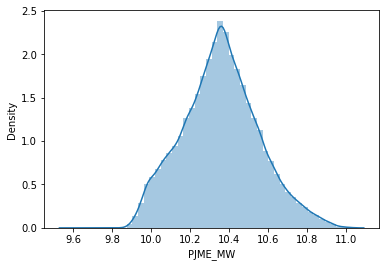

In [26]:
sns.distplot(pjm_df_copy['PJME_MW'])

We can see in EDA section earlier it was right skewed now it is somehow guassain distribution

#### Hypothesis Test to check stationarity

In [27]:
adf_after_transform, pvalue_after_transform, usedlag_, nobs_, critical_values_, icbest_ = adfuller(pjm_df_copy['PJME_MW'])
print("ADF: ", adf_after_transform)
print("p-value: ", pvalue_after_transform)

ADF:  -20.265041208480028
p-value:  0.0


We can see p-value is 0 and ADF value is also negative hence the data is now stationary

##### Encoding categorical columns

In [28]:
pjm_df_copy = pd.get_dummies(pjm_df_copy,columns = ['public_holiday','workaday'])

##### Data Scaling

In [29]:
columns_to_scale = ['lag_feature1','lag_feature2','rolling_day_min','rolling_day_mean','rolling_day_max'
                   ,'rolling_week_min','rolling_week_mean','rolling_week_max','expanding_feature_min',
                   'expanding_feature_mean','expanding_feature_max']


##### Train-Test Split

In [30]:
test_size = 100
df_train = pjm_df_copy[:-test_size]
df_test = pjm_df_copy[-test_size:]
print('Type of df_train :',type(df_train))

Type of df_train : <class 'pandas.core.frame.DataFrame'>


In [31]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
#X_scaler = X.copy()
#X_scaler[X.columns] = scaler.fit_transform(X[X.columns])
#X_scaler
df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

In [32]:
X_train = df_train.drop('PJME_MW',axis=1)
X_test = df_test.drop('PJME_MW',axis=1)
y_train = df_train['PJME_MW']
y_test = df_test['PJME_MW']
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


## Feature Importance

Now we will look at features that are very useful in forecasting or prediction and only keeping those features in our dataset and discard the unimportant features.<br>
There are 3 essential ways to calculate feature importances:<br>
- Method 1 : Feature importances from a tree-based model
- Method 2 : Feature importances from coefficients(linear regression,logistic regression etc)
- Method 3 : Feature importances from PCA
<br>
We will use Method_1 to find feature importance

In [33]:
%%time
random_forest_model = RandomForestRegressor(n_jobs=-1)
                           
random_forest_model.fit(X_train,y_train)

#making dataframe for feature importances
df = {'Columns':X_train.columns,'Feature_importance':random_forest_model.feature_importances_}
feature_imp = pd.DataFrame(df)
feature_imp = feature_imp.sort_values(by='Feature_importance',ascending=False)

Wall time: 2min 36s


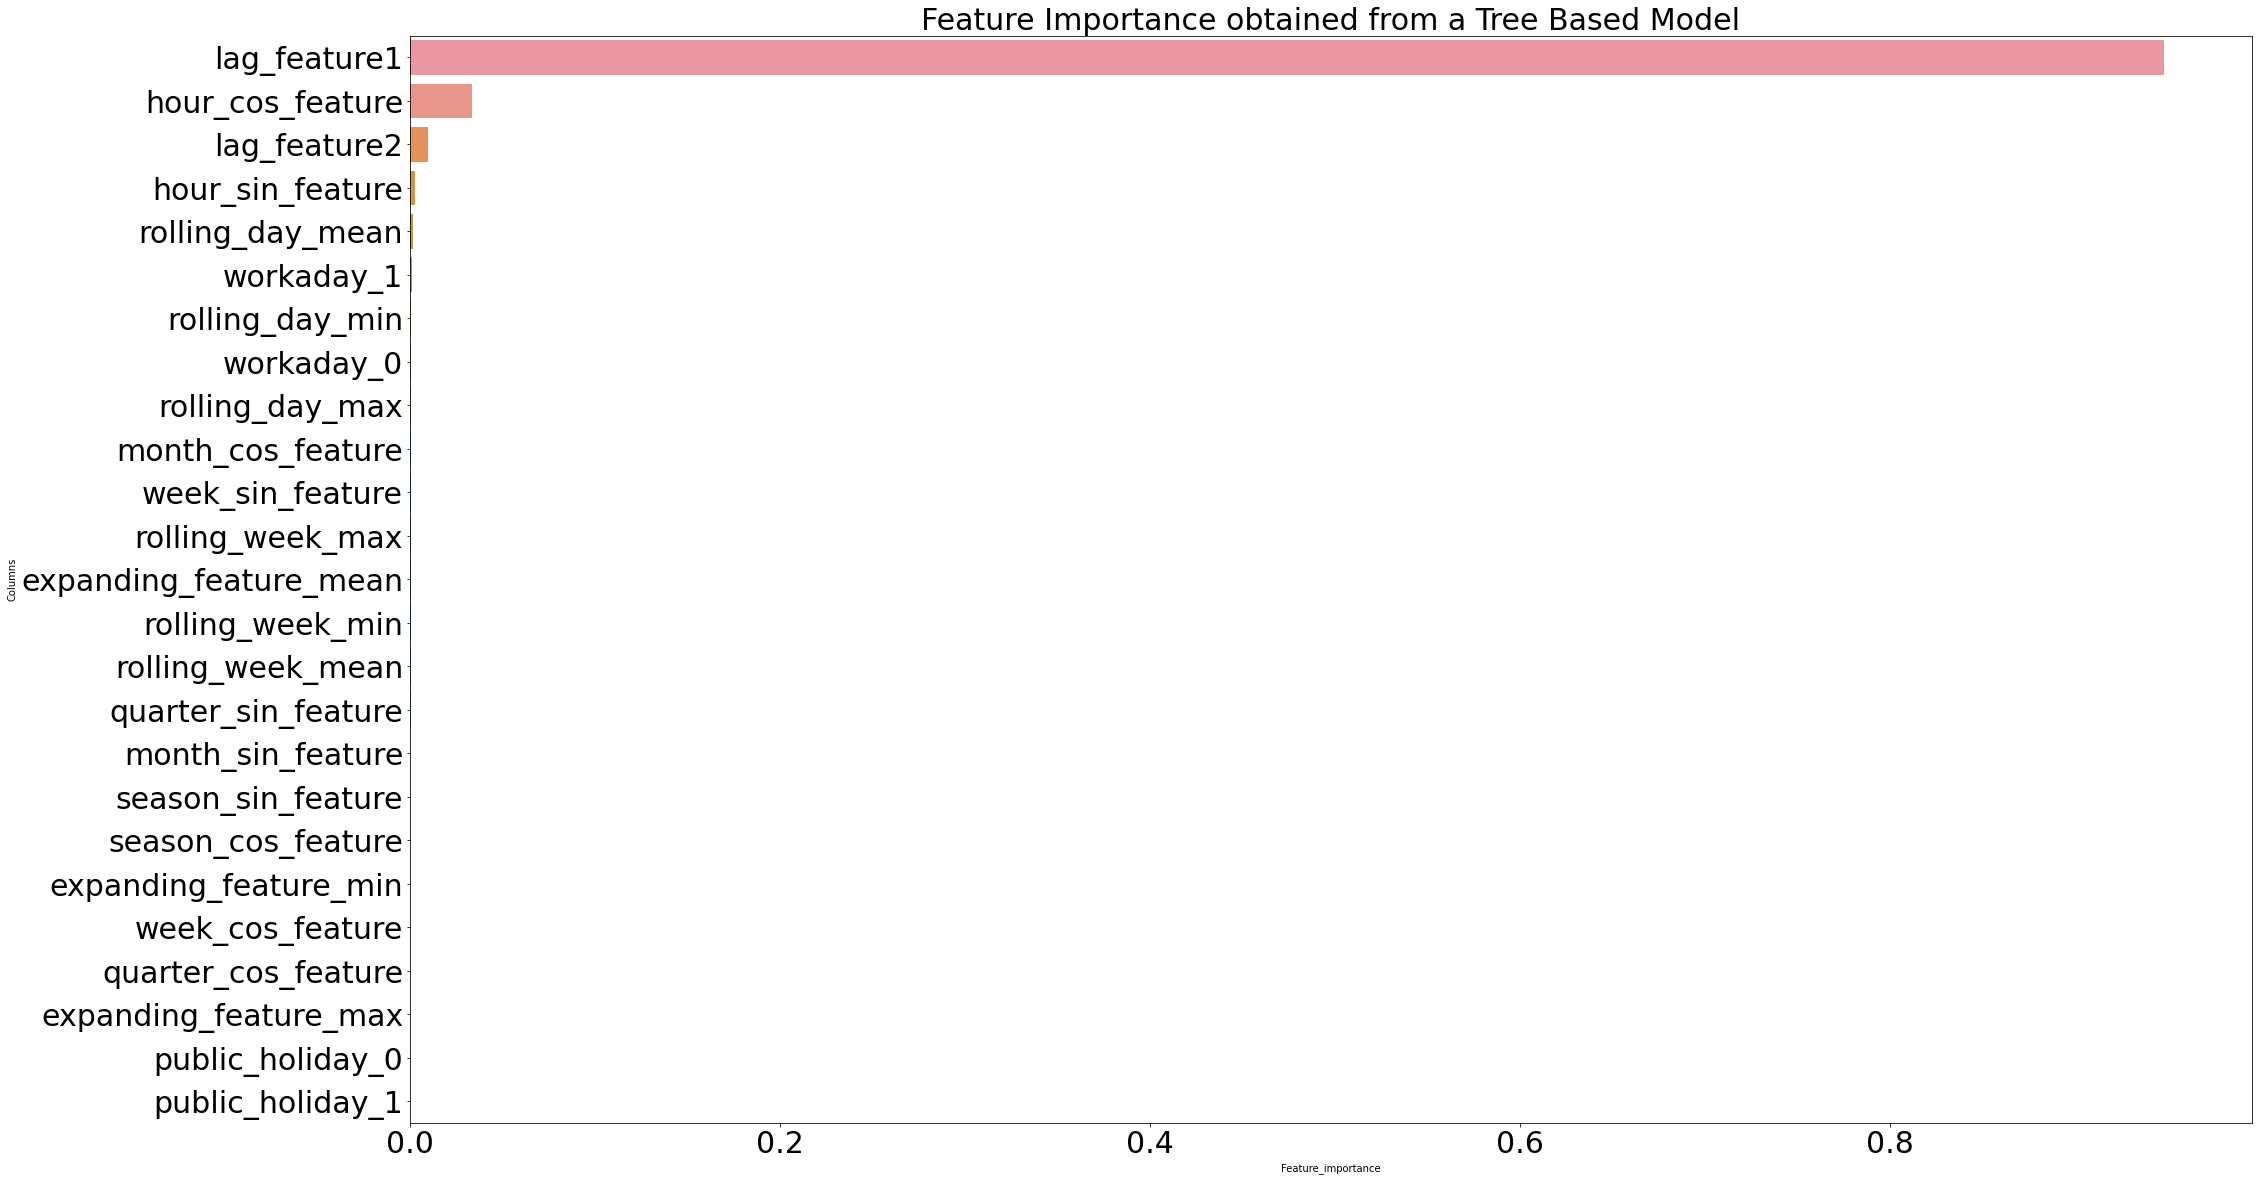

In [41]:
#plt.bar(x=feature_imp['Columns'],height=feature_imp['Feature_importance'])
plt.figure(figsize=(33,20))
sns.barplot(x = "Feature_importance",y = "Columns",data=feature_imp)
plt.title('Feature Importance obtained from a Tree Based Model',size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.show()

In [35]:
final_df = pjm_df_copy.copy()
final_data = final_df[['PJME_MW','lag_feature1','hour_cos_feature','lag_feature2','hour_sin_feature','rolling_day_mean']]

In [36]:
final_data.to_pickle('final_pjm_data.pkl')